In [ ]:
!pip install tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 10.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 5.7 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=42f335d2c99d634a906eb10f4ef399f896d0153aa20bec5978f891d396e6ea14
  Stored in directory: /Users/sandipan/Library/Caches/pip/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
Successfully built promise


# Load data from Tensorflow datasets

https://www.tensorflow.org/datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

print(train_ds.get_shape())

(2569, 150, 150, 3)


# Transfer Learning - VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Two main points: the model has over 14 Million trained parameters and ends with a maxpooling layer that belongs to the Feature Learning part of the network.

In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])


Epoch 1/50
65/65 [==============================] - 10s 130ms/step - loss: 0.1711 - accuracy: 0.9343 - val_loss: 1.7179 - val_accuracy: 0.6576
Epoch 2/50
65/65 [==============================] - 7s 101ms/step - loss: 0.1789 - accuracy: 0.9523 - val_loss: 1.7078 - val_accuracy: 0.6712
Epoch 3/50
65/65 [==============================] - 6s 99ms/step - loss: 0.1028 - accuracy: 0.9703 - val_loss: 1.7048 - val_accuracy: 0.6615
Epoch 4/50
65/65 [==============================] - 6s 100ms/step - loss: 0.0571 - accuracy: 0.9839 - val_loss: 1.7789 - val_accuracy: 0.6790
Epoch 5/50
65/65 [==============================] - 6s 100ms/step - loss: 0.0544 - accuracy: 0.9835 - val_loss: 1.8590 - val_accuracy: 0.6751
Epoch 6/50
65/65 [==============================] - 7s 100ms/step - loss: 0.0512 - accuracy: 0.9869 - val_loss: 1.9106 - val_accuracy: 0.6868
Epoch 7/50
65/65 [==============================] - 6s 99ms/step - loss: 0.0450 - accuracy: 0.9878 - val_loss: 2.0530 - val_accuracy: 0.6751
Epoch 8

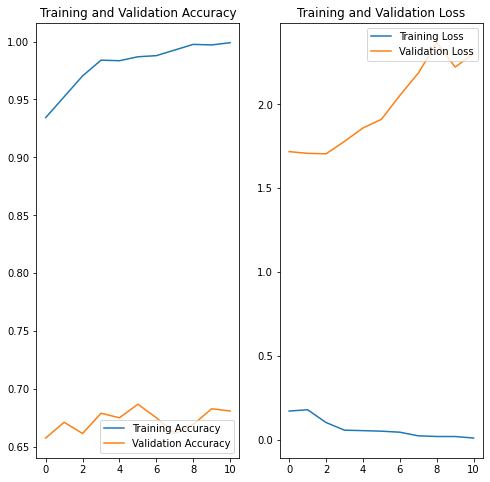

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Transfer Learning ResNet50 - Directly PREDICT

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
# from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
resnet_base_model = ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 4s 0us/step


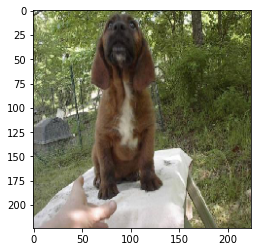

In [ ]:
# Load and resize image to predict
img_path ='/Volumes/GoogleDrive-108421540465873031280/My Drive/GL-AIML-Mentoring/ai-ml-explainers/My-way-NN/data/images/5.jpg'
imgToPredict = tf.keras.preprocessing.image.load_img(img_path, target_size=[224, 224])
plt.imshow(imgToPredict)

In [ ]:
# convert to numpy array
imgArr = tf.keras.preprocessing.image.img_to_array(imgToPredict)
imgArr.shape

(224, 224, 3)

In [ ]:
# add the #of image dimension
img_arr_dim = tf.expand_dims(imgArr, 0)
img_arr_dim.shape

TensorShape([1, 224, 224, 3])

In [ ]:
# prediction
prediction = resnet_base_model.predict(img_arr_dim)
tf.keras.applications.resnet50.decode_predictions(prediction)

[[('n02088238', 'basset', 0.24320555),
  ('n02088466', 'bloodhound', 0.2076513),
  ('n02102318', 'cocker_spaniel', 0.18374951),
  ('n02100735', 'English_setter', 0.0913627),
  ('n02091635', 'otterhound', 0.028381119)]]